In [1]:
import time
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import dgl
import networkx as nx
import torch
import torch.nn as nn

import utils
from gsp_utils.baselines_archs import GCNN_2L
from gsp_utils.baselines_models import NodeClassModel, GF_NodeClassModel
from gsp_utils.data import normalize_gso
from src.arch import GFGCN, GFGCNLayer, GFGCN_noh_Layer, GFGCN_Spows

SEED = 15
# PATH = 'results/diff_filters/'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

torch.manual_seed(SEED)

cuda:0


In [2]:
# Auxiliary functions
def summary_table(acc, index_name):
    mean_accs = acc.mean(axis=1)
    med_accs = np.median(acc, axis=1)
    std_accs = acc.std(axis=1)
    return DataFrame(np.vstack((mean_accs, med_accs, std_accs)).T, columns=['mean accs', 'med', 'std'], index=index_name)

In [3]:
# Auxiliary functions
def compute_S_pows(S, K, device):
    N = S.shape[0]
    S_pows = torch.Tensor(torch.empty(K-1, N, N)).to(device)
    S_pows[0,:,:] = torch.Tensor(S).to(device)
    for k in range(1,K-1):
        S_pows[k,:,:] = S_pows[0,:,:] @ S_pows[k-1,:,:]

    return S_pows

In [4]:
# Dataset must be from DGL
dataset_name = 'CornellDataset'

A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device,
                                                     verb=True)
N = A.shape[0]

Dataset: CornellDataset
Number of nodes: 183
Number of features: 1703
Shape of signals: torch.Size([183, 1703])
Number of classes: 5
Norm of A: 17.262676239013672
Max value of A: 1.0
Proportion of validation data: 0.32
Proportion of test data: 0.20
Node homophily: 0.11
Edge homophily: 0.13


In [24]:
# BEST PARAMETERS
## Reaining params
N_RUNS = 10
N_EPOCHS = 500  # 5000
EPOCHS_h = 5 # 5 # 5
EPOCHS_W = 10 # 5 # 25
LR = .005
WD = .01
DROPOUT = 0

# BEST PARAMETERS
## Architecture params
N_LAYERS = 2
K = 2
HID_DIM = 64 # 100

## Model params
NORM = True

IN_DIM = feat.shape[1]
OUT_DIM = n_class

ACT = nn.ELU()  # nn.ReLU()
LAST_ACT = nn.Softmax(dim=1)
LOSS_FN = nn.CrossEntropyLoss()  # nn.CrossEntropyLoss()

## Plotting eval/test acc/loss

In [6]:
# Parameters
epochs = 500
epochs_h = 1
epochs_W = 1
lr = .005
wd = .01
drop = 0
L = N_LAYERS
K_aux = K
hid_dim = 16
norm = True
act = ACT
lact = LAST_ACT
loss = LOSS_FN

# Create model
arch = GFGCN_Spows(IN_DIM, hid_dim, OUT_DIM, L, K_aux, act=act, last_act=lact,
            dropout=drop, norm=norm, dev=device)
S = torch.Tensor(A).to(device)
model = GF_NodeClassModel(arch, S, K, masks, LOSS_FN, device=device)
loss, acc = model.train(feat, labels, epochs, lr, wd, epochs_h=epochs_h, epochs_W=epochs_W)

idx_max_acc = np.argmax(acc["val"])
print(f'Best val acc: {acc["val"][idx_max_acc]:.3f}')
print(f'Test acc at best val: {acc["test"][idx_max_acc]:.3f}')
print(f'Best test acc: {np.max(acc["test"]):.3f}')

Best val acc: 0.831
Test acc at best val: 0.730
Best test acc: 0.838


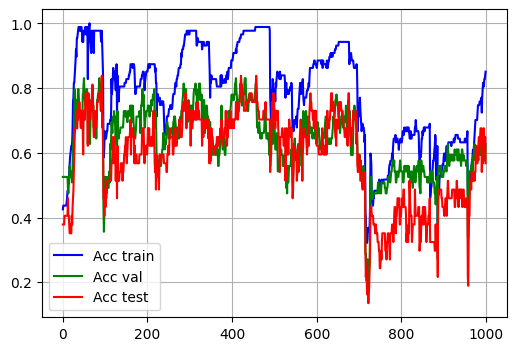

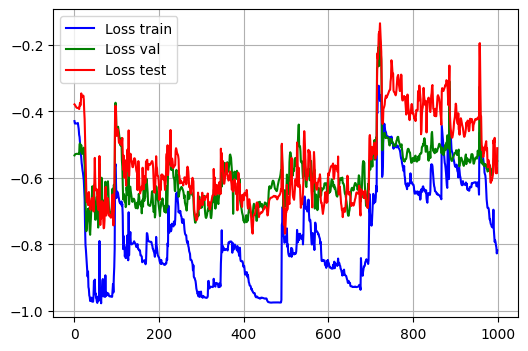

In [7]:
# Plot
plt.figure(figsize=[6,4])
plt.plot(acc['train'], 'b-', label='Acc train')
plt.plot(acc['val'], 'g-', label='Acc val')
plt.plot(acc['test'], 'r-', label='Acc test')
plt.grid()
plt.legend()

plt.figure(figsize=[6,4])
plt.plot(loss['train'], 'b-', label='Loss train')
plt.plot(loss['val'], 'g-', label='Loss val')
plt.plot(loss['test'], 'r-', label='Loss test')
plt.grid()
plt.legend()

## Training paramerters

In [8]:
EXPS = [
        # {'epochs': 200, 'lr': .5, 'wd': 5e-4, 'drop': 0},
        # {'epochs': 200, 'lr': .1, 'wd': 5e-4, 'drop': 0},
        # {'epochs': 200, 'lr': .05, 'wd': 5e-4, 'drop': 0},
        # {'epochs': 200, 'lr': .01, 'wd': 5e-4, 'drop': 0},
        # {'epochs': 200, 'lr': .001, 'wd': 5e-4, 'drop': 0},
        
        {'epochs': 200, 'lr': .01, 'wd': 1e-3, 'drop': 0},
        {'epochs': 200, 'lr': .01, 'wd': 1e-2, 'drop': 0},
        {'epochs': 200, 'lr': .01, 'wd': 5e-2, 'drop': 0},

        {'epochs': 200, 'lr': .05, 'wd': 1e-3, 'drop': 0},
        {'epochs': 200, 'lr': .05, 'wd': 1e-2, 'drop': 0},
        {'epochs': 200, 'lr': .05, 'wd': 5e-2, 'drop': 0},
        
        {'epochs': 500, 'lr': .1, 'wd': 1e-2, 'drop': 0},
        {'epochs': 500, 'lr': .05, 'wd': 1e-2, 'drop': 0},
        {'epochs': 500, 'lr': .01, 'wd': 1e-2, 'drop': 0},
        {'epochs': 500, 'lr': .005, 'wd': 1e-2, 'drop': 0},

        {'epochs': 200, 'lr': .05, 'wd': 1e-2, 'drop': .25},
        {'epochs': 200, 'lr': .05, 'wd': 1e-2, 'drop': .5},
        # {'epochs': 200, 'lr': .05, 'wd': 1e-2, 'drop': .75},
        {'epochs': 500, 'lr': .05, 'wd': 1e-2, 'drop': .25},
        {'epochs': 500, 'lr': .05, 'wd': 1e-2, 'drop': .5},
        # {'epochs': 500, 'lr': .05, 'wd': 1e-2, 'drop': .75},

        {'epochs': 1000, 'lr': .05, 'wd': 1e-2, 'drop': 0},
        {'epochs': 1000, 'lr': .01, 'wd': 1e-2, 'drop': 0},
        {'epochs': 1000, 'lr': .05, 'wd': 1e-2, 'drop': .25},
        {'epochs': 1000, 'lr': .01, 'wd': 1e-2, 'drop': .25},
        ]

best_accs1 = np.zeros((len(EXPS), N_RUNS))
best_val_accs1 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i)
    for j, exp in enumerate(EXPS):        
        arch = GFGCN_Spows(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                           dropout=exp['drop'], norm=NORM, dev=device)
        S = torch.Tensor(A).to(device)

        model = GF_NodeClassModel(arch, S, K, masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, exp['epochs'], exp['lr'], exp['wd'],
                             epochs_h=EPOCHS_h, epochs_W=EPOCHS_W)

        best_accs1[j,i] = np.max(acc["test"])
        best_val_accs1[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["epochs"]}-{exp["lr"]}-{exp["wd"]}-{exp["drop"]}: {best_val_accs1[j,i]:.3f} ({best_accs1[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["epochs"]}-{exp["lr"]}-{exp["wd"]}-{exp["drop"]}' for exp in EXPS]
table_over1 = summary_table(best_accs1, index_name)
table1 = summary_table(best_val_accs1, index_name)

-1: 200-0.01-0.001-0: 0.811 (0.838)
-1: 200-0.01-0.01-0: 0.811 (0.865)
-1: 200-0.01-0.05-0: 0.757 (0.811)
-1: 200-0.05-0.001-0: 0.459 (0.459)
-1: 200-0.05-0.01-0: 0.676 (0.703)
-1: 200-0.05-0.05-0: 0.784 (0.811)
-1: 500-0.1-0.01-0: 0.757 (0.811)
-1: 500-0.05-0.01-0: 0.730 (0.919)
-1: 500-0.01-0.01-0: 0.730 (0.865)
-1: 500-0.005-0.01-0: 0.784 (0.838)
-1: 200-0.05-0.01-0.25: 0.568 (0.703)
-1: 200-0.05-0.01-0.5: 0.730 (0.811)
-1: 500-0.05-0.01-0.25: 0.730 (0.838)
-1: 500-0.05-0.01-0.5: 0.730 (0.838)
-1: 1000-0.05-0.01-0: 0.703 (0.811)
-1: 1000-0.01-0.01-0: 0.730 (0.892)
-1: 1000-0.05-0.01-0.25: 0.730 (0.838)
-1: 1000-0.01-0.01-0.25: 0.784 (0.865)
-2: 200-0.01-0.001-0: 0.784 (0.865)
-2: 200-0.01-0.01-0: 0.676 (0.784)
-2: 200-0.01-0.05-0: 0.703 (0.757)
-2: 200-0.05-0.001-0: 0.703 (0.757)
-2: 200-0.05-0.01-0: 0.703 (0.838)
-2: 200-0.05-0.05-0: 0.568 (0.649)
-2: 500-0.1-0.01-0: 0.595 (0.784)
-2: 500-0.05-0.01-0: 0.568 (0.865)
-2: 500-0.01-0.01-0: 0.811 (0.838)
-2: 500-0.005-0.01-0: 0.784 (0.8

In [9]:
table1

,mean accs,med,std
200-0.01-0.001-0,0.700000,0.689189,0.058531
200-0.01-0.01-0,0.718919,0.743243,0.059459
200-0.01-0.05-0,0.702703,0.702703,0.041870
200-0.05-0.001-0,0.635135,0.662162,0.112901
200-0.05-0.01-0,0.689189,0.702703,0.091454
200-0.05-0.05-0,0.683784,0.689189,0.077441
500-0.1-0.01-0,0.713514,0.743243,0.063037
500-0.05-0.01-0,0.678378,0.716216,0.074948
500-0.01-0.01-0,0.740541,0.729730,0.036661
500-0.005-0.01-0,0.754054,0.770270,0.053306


In [10]:
table_over1

,mean accs,med,std
200-0.01-0.001-0,0.781081,0.783784,0.051917
200-0.01-0.01-0,0.797297,0.797297,0.036761
200-0.01-0.05-0,0.791892,0.810811,0.041957
200-0.05-0.001-0,0.700000,0.729730,0.107056
200-0.05-0.01-0,0.764865,0.797297,0.082907
200-0.05-0.05-0,0.740541,0.756757,0.052962
500-0.1-0.01-0,0.816216,0.810811,0.033757
500-0.05-0.01-0,0.832432,0.824324,0.041520
500-0.01-0.01-0,0.810811,0.824324,0.048347
500-0.005-0.01-0,0.818919,0.837838,0.034293


## Model params

In [11]:
# h0, norm (norm, not norm, norm H), sep vs joint training, optimizers iters (W vs h)
EXPS = [
        {'epochs': 500, 'epochs_h': 1, 'epochs_W': 1, 'alt': True},        
        {'epochs': 500, 'epochs_h': 1, 'epochs_W': 1, 'alt': False},

        {'epochs': 500, 'epochs_h': 5, 'epochs_W': 1, 'alt': True},
        {'epochs': 500, 'epochs_h': 10, 'epochs_W': 1, 'alt': True},
        {'epochs': 500, 'epochs_h': 25, 'epochs_W': 1, 'alt': True},
        {'epochs': 500, 'epochs_h': 25, 'epochs_W': 5, 'alt': True},

        {'epochs': 1000, 'epochs_h': 5, 'epochs_W': 1, 'alt': True},

        {'epochs': 500, 'epochs_h': 1, 'epochs_W': 5, 'alt': True},
        {'epochs': 500, 'epochs_h': 1, 'epochs_W': 10, 'alt': True},
        {'epochs': 500, 'epochs_h': 1, 'epochs_W': 25, 'alt': True},
        {'epochs': 500, 'epochs_h': 5, 'epochs_W': 25, 'alt': True},

        {'epochs': 500, 'epochs_h': 10, 'epochs_W': 10, 'alt': True},
        {'epochs': 500, 'epochs_h': 25, 'epochs_W': 25, 'alt': True},
        {'epochs': 500, 'epochs_h': 50, 'epochs_W': 50, 'alt': True},
        {'epochs': 100, 'epochs_h': 10, 'epochs_W': 10, 'alt': True},
        {'epochs': 100, 'epochs_h': 25, 'epochs_W': 25, 'alt': True},]


best_accs2 = np.zeros((len(EXPS), N_RUNS))
best_val_accs2 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i)
    for j, exp in enumerate(EXPS):
        arch = GFGCN_Spows(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                           dropout=DROPOUT, norm=NORM, dev=device)
        S = torch.Tensor(A).to(device)

        if not exp['alt']:
            S_pows = compute_S_pows(A, K, device)
            model = NodeClassModel(arch, S_pows, masks, LOSS_FN, device=device)
            _, acc = model.train(feat, labels, exp['epochs'], LR, WD)
        else:
            model = GF_NodeClassModel(arch, S,  K, masks, LOSS_FN, device=device)
            _, acc = model.train(feat, labels, exp['epochs'], LR, WD, epochs_h=exp['epochs_h'],
                                 epochs_W=exp['epochs_W'])

        best_accs2[j,i] = np.max(acc["test"])
        best_val_accs2[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["epochs_h"]}-{exp["epochs_W"]}-{exp["alt"]}: {best_val_accs2[j,i]:.3f} ({best_accs2[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["epochs"]}-{exp["epochs_h"]}-{exp["epochs_W"]}-{exp["alt"]}' for exp in EXPS]
table_over2 = summary_table(best_accs2, index_name)
table2 = summary_table(best_val_accs2, index_name)

-1: 1-1-True: 0.784 (0.892)
-1: 1-1-True: 0.730 (0.811)
-1: 1-1-False: 0.784 (0.838)
-1: 5-1-True: 0.838 (0.865)
-1: 10-1-True: 0.784 (0.838)
-1: 25-1-True: 0.784 (0.892)
-1: 25-5-True: 0.730 (0.865)
-1: 5-1-True: 0.838 (0.865)
-1: 1-5-True: 0.757 (0.865)
-1: 1-10-True: 0.730 (0.838)
-1: 1-25-True: 0.757 (0.838)
-1: 5-25-True: 0.730 (0.838)
-1: 10-10-True: 0.784 (0.865)
-1: 25-25-True: 0.703 (0.838)
-1: 50-50-True: 0.730 (0.811)
-1: 10-10-True: 0.811 (0.892)
-1: 25-25-True: 0.757 (0.838)
-2: 1-1-True: 0.730 (0.838)
-2: 1-1-True: 0.676 (0.838)
-2: 1-1-False: 0.730 (0.811)
-2: 5-1-True: 0.703 (0.757)
-2: 10-1-True: 0.676 (0.784)
-2: 25-1-True: 0.568 (0.784)
-2: 25-5-True: 0.730 (0.838)
-2: 5-1-True: 0.703 (0.784)
-2: 1-5-True: 0.676 (0.838)
-2: 1-10-True: 0.730 (0.838)
-2: 1-25-True: 0.730 (0.838)
-2: 5-25-True: 0.730 (0.811)
-2: 10-10-True: 0.703 (0.865)
-2: 25-25-True: 0.703 (0.811)
-2: 50-50-True: 0.676 (0.784)
-2: 10-10-True: 0.811 (0.811)
-2: 25-25-True: 0.730 (0.811)
-3: 1-1-True: 

In [12]:
table2

,mean accs,med,std
500-1-1-True,0.735135,0.743243,0.039721
500-1-1-True,0.710811,0.716216,0.036361
500-1-1-False,0.718919,0.729730,0.060676
500-5-1-True,0.735135,0.716216,0.064865
500-10-1-True,0.735135,0.756757,0.084435
500-25-1-True,0.683784,0.675676,0.049909
500-25-5-True,0.737838,0.729730,0.060495
1000-5-1-True,0.713514,0.702703,0.055652
500-1-5-True,0.735135,0.743243,0.037838
500-1-10-True,0.729730,0.729730,0.051280


In [13]:
table_over2

,mean accs,med,std
500-1-1-True,0.827027,0.837838,0.042218
500-1-1-True,0.800000,0.810811,0.036661
500-1-1-False,0.810811,0.824324,0.040088
500-5-1-True,0.802703,0.770270,0.051351
500-10-1-True,0.791892,0.797297,0.055455
500-25-1-True,0.805405,0.810811,0.039721
500-25-5-True,0.816216,0.824324,0.035855
1000-5-1-True,0.821622,0.824324,0.036661
500-1-5-True,0.813514,0.824324,0.035135
500-1-10-True,0.802703,0.797297,0.034293


## Architecture design

In [14]:
# layers, filter order, weightd
EXPS = [{'L': 2, 'K': 2, 'hid_dim': 16},
        {'L': 2, 'K': 3, 'hid_dim': 16},
        # {'L': 2, 'K': 4, 'hid_dim': 16},

        {'L': 3, 'K': 2, 'hid_dim': 16},
        {'L': 4, 'K': 2, 'hid_dim': 16},
        {'L': 3, 'K': 3, 'hid_dim': 16},
        # {'L': 4, 'K': 3, 'hid_dim': 16},

        # {'L': 2, 'K': 2, 'hid_dim': 8},
        {'L': 2, 'K': 2, 'hid_dim': 32},
        {'L': 2, 'K': 2, 'hid_dim': 64},
        {'L': 2, 'K': 2, 'hid_dim': 128},
        {'L': 2, 'K': 2, 'hid_dim': 256},

        # {'L': 2, 'K': 3, 'hid_dim': 32},
        # {'L': 2, 'K': 3, 'hid_dim': 50},
        # {'L': 2, 'K': 3, 'hid_dim': 75},
        {'L': 2, 'K': 3, 'hid_dim': 100},

        # {'L': 3, 'K': 2, 'hid_dim': 50},
        # {'L': 3, 'K': 3, 'hid_dim': 50},
        ]

best_accs3 = np.zeros((len(EXPS), N_RUNS))
best_val_accs3 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i)
    for j, exp in enumerate(EXPS):
        arch = GFGCN_Spows(IN_DIM, exp['hid_dim'], OUT_DIM, exp['L'], exp['K'], act=ACT, last_act=LAST_ACT,
                           dropout=DROPOUT, norm=NORM, dev=device)
        S = torch.Tensor(A).to(device)

        model = GF_NodeClassModel(arch, S,  exp['K'], masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD, epochs_h=EPOCHS_h, epochs_W=EPOCHS_W)

        best_accs3[j,i] = np.max(acc["test"])
        best_val_accs3[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["L"]}-{exp["K"]}-{exp["hid_dim"]}: {best_val_accs3[j,i]:.3f} ({best_accs3[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["L"]}-{exp["K"]}-{exp["hid_dim"]}' for exp in EXPS]
table_over3 = summary_table(best_accs3, index_name)
table3 = summary_table(best_val_accs3, index_name)

-1: 2-2-16: 0.784 (0.892)
-1: 2-3-16: 0.892 (0.892)
-1: 2-4-16: 0.541 (0.649)
-1: 3-2-16: 0.676 (0.838)
-1: 4-2-16: 0.649 (0.757)
-1: 3-3-16: 0.595 (0.703)
-1: 4-3-16: 0.514 (0.541)
-1: 2-2-8: 0.757 (0.838)
-1: 2-2-32: 0.730 (0.838)
-1: 2-2-50: 0.811 (0.865)
-1: 2-2-75: 0.730 (0.838)
-1: 2-2-100: 0.838 (0.865)
-1: 2-3-32: 0.676 (0.757)
-1: 2-3-50: 0.811 (0.838)
-1: 2-3-75: 0.757 (0.865)
-1: 2-3-100: 0.757 (0.784)
-1: 3-2-50: 0.757 (0.865)
-1: 3-3-50: 0.622 (0.811)
-2: 2-2-16: 0.703 (0.784)
-2: 2-3-16: 0.622 (0.730)
-2: 2-4-16: 0.486 (0.595)
-2: 3-2-16: 0.676 (0.784)
-2: 4-2-16: 0.622 (0.703)
-2: 3-3-16: 0.486 (0.541)
-2: 4-3-16: 0.432 (0.459)
-2: 2-2-8: 0.622 (0.757)
-2: 2-2-32: 0.730 (0.838)
-2: 2-2-50: 0.757 (0.892)
-2: 2-2-75: 0.676 (0.838)
-2: 2-2-100: 0.811 (0.865)
-2: 2-3-32: 0.730 (0.784)
-2: 2-3-50: 0.432 (0.622)
-2: 2-3-75: 0.811 (0.838)
-2: 2-3-100: 0.757 (0.811)
-2: 3-2-50: 0.649 (0.811)
-2: 3-3-50: 0.432 (0.595)
-3: 2-2-16: 0.730 (0.865)
-3: 2-3-16: 0.541 (0.730)
-3: 2-4-16

In [15]:
table3

,mean accs,med,std
2-2-16,0.721622,0.716216,0.041957
2-3-16,0.618919,0.621622,0.132101
2-4-16,0.570270,0.554054,0.082377
3-2-16,0.705405,0.716216,0.047509
4-2-16,0.648649,0.662162,0.081081
3-3-16,0.567568,0.554054,0.089639
4-3-16,0.497297,0.527027,0.103411
2-2-8,0.702703,0.702703,0.065090
2-2-32,0.721622,0.729730,0.055455
2-2-50,0.745946,0.756757,0.058218


In [16]:
table_over3

,mean accs,med,std
2-2-16,0.808108,0.810811,0.050491
2-3-16,0.716216,0.729730,0.110943
2-4-16,0.656757,0.648649,0.073571
3-2-16,0.802703,0.810811,0.029730
4-2-16,0.724324,0.756757,0.075289
3-3-16,0.651351,0.662162,0.086697
4-3-16,0.562162,0.594595,0.062572
2-2-8,0.781081,0.783784,0.040899
2-2-32,0.818919,0.824324,0.036361
2-2-50,0.827027,0.824324,0.032432


## Nonlinearities and loss function

In [17]:
# layers, filter order, weightd
EXPS = [{'act': nn.ReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.ReLU(), 'lact': nn.LogSoftmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ReLU(), 'lact': nn.LogSoftmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.ReLU(), 'lact': nn.Identity(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ReLU(), 'lact': nn.Identity(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.ELU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ELU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.LeakyReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.LeakyReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.Identity(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.Identity(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.Identity(), 'lact': nn.Identity(dim=1), 'loss': nn.CrossEntropyLoss()},]

best_accs4 = np.zeros((len(EXPS), N_RUNS))
best_val_accs4 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i)
    for j, exp in enumerate(EXPS):
        arch = GFGCN_Spows(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=exp['act'], last_act=exp['lact'],
                           dropout=DROPOUT, norm=NORM, dev=device)
        S = torch.Tensor(A).to(device)

        model = GF_NodeClassModel(arch, S,  K, masks, exp['loss'], device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD, epochs_h=EPOCHS_h, epochs_W=EPOCHS_W)

        best_accs4[j,i] = np.max(acc["test"])
        best_val_accs4[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["act"]}-{exp["lact"]}-{exp["loss"]}: {best_val_accs4[j,i]:.3f} ({best_accs4[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["act"]}-{exp["lact"]}-{exp["loss"]}' for exp in EXPS]
table_over4 = summary_table(best_accs4, index_name)
table4 = summary_table(best_val_accs4, index_name)

-1: ReLU()-Softmax(dim=1)-CrossEntropyLoss(): 0.838 (0.865)
-1: ReLU()-Softmax(dim=1)-NLLLoss(): 0.757 (0.892)
-1: ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(): 0.703 (0.811)
-1: ReLU()-LogSoftmax(dim=1)-NLLLoss(): 0.622 (0.757)
-1: ReLU()-Identity()-CrossEntropyLoss(): 0.676 (0.703)
-1: ReLU()-Identity()-NLLLoss(): 0.514 (0.514)
-1: ELU(alpha=1.0)-Softmax(dim=1)-CrossEntropyLoss(): 0.703 (0.811)
-1: ELU(alpha=1.0)-Softmax(dim=1)-NLLLoss(): 0.784 (0.838)
-1: LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-CrossEntropyLoss(): 0.784 (0.892)
-1: LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-NLLLoss(): 0.730 (0.838)
-1: Identity()-Softmax(dim=1)-CrossEntropyLoss(): 0.784 (0.865)
-1: Identity()-Softmax(dim=1)-NLLLoss(): 0.811 (0.865)
-1: Identity()-Identity()-CrossEntropyLoss(): 0.757 (0.811)
-2: ReLU()-Softmax(dim=1)-CrossEntropyLoss(): 0.730 (0.838)
-2: ReLU()-Softmax(dim=1)-NLLLoss(): 0.703 (0.838)
-2: ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(): 0.757 (0.865)
-2: ReLU()-LogSoftmax(dim=1)-N

In [18]:
table4

,mean accs,med,std
ReLU()-Softmax(dim=1)-CrossEntropyLoss(),0.724324,0.716216,0.060192
ReLU()-Softmax(dim=1)-NLLLoss(),0.740541,0.756757,0.034611
ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(),0.727027,0.729730,0.068853
ReLU()-LogSoftmax(dim=1)-NLLLoss(),0.729730,0.743243,0.059213
ReLU()-Identity()-CrossEntropyLoss(),0.689189,0.689189,0.073769
ReLU()-Identity()-NLLLoss(),0.462162,0.486486,0.083259
ELU(alpha=1.0)-Softmax(dim=1)-CrossEntropyLoss(),0.745946,0.743243,0.042218
ELU(alpha=1.0)-Softmax(dim=1)-NLLLoss(),0.732432,0.743243,0.064470
LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-CrossEntropyLoss(),0.732432,0.729730,0.081485
LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-NLLLoss(),0.724324,0.729730,0.065981


In [19]:
table_over4

,mean accs,med,std
ReLU()-Softmax(dim=1)-CrossEntropyLoss(),0.821622,0.824324,0.038602
ReLU()-Softmax(dim=1)-NLLLoss(),0.827027,0.837838,0.038602
ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(),0.786486,0.783784,0.049023
ReLU()-LogSoftmax(dim=1)-NLLLoss(),0.786486,0.783784,0.035135
ReLU()-Identity()-CrossEntropyLoss(),0.778378,0.783784,0.057714
ReLU()-Identity()-NLLLoss(),0.518919,0.527027,0.046499
ELU(alpha=1.0)-Softmax(dim=1)-CrossEntropyLoss(),0.827027,0.837838,0.027562
ELU(alpha=1.0)-Softmax(dim=1)-NLLLoss(),0.816216,0.810811,0.023562
LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-CrossEntropyLoss(),0.827027,0.810811,0.036661
LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-NLLLoss(),0.805405,0.797297,0.037838


# Comparing Models

In [25]:
EXPS = [
        # {'name': 'Kipf', 'norm': 'none'},
        {'name': 'Kipf', 'norm': 'both'},

        {'name': 'A-GCNN', 'norm': False},
        # {'name': 'A-GCNN', 'norm': True},

        {'name': 'H-GCNN', 'norm': False},
        {'name': 'H-GCNN', 'norm': True},

        {'name': 'W-GCN-A', 'norm': False},
        # {'name': 'W-GCN-A', 'norm': True},
]

In [26]:
N_RUNS = 10

best_accs = np.zeros((len(EXPS), N_RUNS))
best_val_accs = np.zeros((len(EXPS), N_RUNS))
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i)
    print(f'- RUN: {i+1}')
    for j, exp in enumerate(EXPS):
        # t_i = time.time()
        if exp['name'] == 'Kipf':
            arch = GCNN_2L(IN_DIM, HID_DIM, OUT_DIM, act=ACT, last_act=LAST_ACT,
                           dropout=DROPOUT, norm=exp['norm'])
            S = dgl.from_networkx(nx.from_numpy_array(A)).add_self_loop().to(device)
            
        elif exp['name'] == 'A-GCNN':
            arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
            dropout=DROPOUT, diff_layer=GFGCNLayer, init_h0=.1)
            if exp['norm']:
                S = torch.Tensor(normalize_gso(A, 'both')).to(device)
            else:
                S = torch.Tensor(A).to(device)

        elif exp['name'] == 'H-GCNN':
            arch = GFGCN_Spows(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                               dropout=DROPOUT, norm=exp['norm'], dev=device)
            S = torch.Tensor(A).to(device)

        elif exp['name'] == 'W-GCN-A':
            arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                         dropout=DROPOUT, diff_layer=GFGCN_noh_Layer)
            if exp['norm']:
                S = torch.Tensor(normalize_gso(A, 'both')).to(device)
            else:
                S = torch.Tensor(A).to(device)  
            
        else:
            raise Exception(f'ERROR: Unknown architecture: {exp["name"]}')

        if exp['name'] in ['Kipf', 'W-GCN-A']:
            model = NodeClassModel(arch, S, masks, LOSS_FN, device=device)
            loss, acc = model.train(feat, labels, N_EPOCHS, LR, WD)
        else:
            model = GF_NodeClassModel(arch, S, K, masks, LOSS_FN, device=device)
            loss, acc = model.train(feat, labels, N_EPOCHS, LR, WD, epochs_h=EPOCHS_h,
                                    epochs_W=EPOCHS_W)
        

        best_accs[j,i] = np.max(acc["test"])
        best_val_accs[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'\t{exp["name"]}-{exp["norm"]}: acc = {best_val_accs[j,i]:.3f}  -  acc (over) = {best_accs[j,i]:.3f}')


# Print results
index_name = [f'{exp["name"]}-{exp["norm"]}' for exp in EXPS]
table_comp_over = summary_table(best_accs, index_name)
table_comp = summary_table(best_val_accs, index_name)
        

- RUN: 1
	Kipf-both: acc = 0.514  -  acc (over) = 0.622
	A-GCNN-False: acc = 0.703  -  acc (over) = 0.730
	H-GCNN-False: acc = 0.703  -  acc (over) = 0.757
	H-GCNN-True: acc = 0.730  -  acc (over) = 0.838
	W-GCN-A-False: acc = 0.811  -  acc (over) = 0.838
- RUN: 2
	Kipf-both: acc = 0.378  -  acc (over) = 0.459
	A-GCNN-False: acc = 0.757  -  acc (over) = 0.838
	H-GCNN-False: acc = 0.784  -  acc (over) = 0.838
	H-GCNN-True: acc = 0.811  -  acc (over) = 0.838
	W-GCN-A-False: acc = 0.703  -  acc (over) = 0.703
- RUN: 3
	Kipf-both: acc = 0.541  -  acc (over) = 0.568
	A-GCNN-False: acc = 0.838  -  acc (over) = 0.865
	H-GCNN-False: acc = 0.838  -  acc (over) = 0.865
	H-GCNN-True: acc = 0.784  -  acc (over) = 0.784
	W-GCN-A-False: acc = 0.757  -  acc (over) = 0.784
- RUN: 4
	Kipf-both: acc = 0.378  -  acc (over) = 0.622
	A-GCNN-False: acc = 0.757  -  acc (over) = 0.784
	H-GCNN-False: acc = 0.730  -  acc (over) = 0.757
	H-GCNN-True: acc = 0.703  -  acc (over) = 0.811
	W-GCN-A-False: acc = 0.676

In [27]:
table_comp

,mean accs,med,std
Kipf-both,0.502703,0.527027,0.072722
A-GCNN-False,0.743243,0.743243,0.067568
H-GCNN-False,0.740541,0.716216,0.069644
H-GCNN-True,0.732432,0.729730,0.044328
W-GCN-A-False,0.724324,0.716216,0.055125


In [28]:
table_comp_over

,mean accs,med,std
Kipf-both,0.570270,0.581081,0.057269
A-GCNN-False,0.767568,0.756757,0.066423
H-GCNN-False,0.767568,0.756757,0.069644
H-GCNN-True,0.808108,0.810811,0.028217
W-GCN-A-False,0.772973,0.770270,0.038602
